# Kuramoto Synchrobiology Playground

Based on https://github.com/fabridamicelli/kuramoto

In [1]:
import asyncio
import time
import traceback
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy import integrate
from pythonosc.udp_client import SimpleUDPClient

# Global State
message_rate = 0.1 # inverse of sampling rate of messages to synthesizer (period in seconds)

# number of euler steps calculated per message sent to synthesizer
# use this to balance simulation accuracy against sending too many messages
# together with message rate this paramater also controls the realtime speed of the simulation
euler_steps_per_message = 10
send_osc = True
print_every = 10
run_simulation = True
osc_client = None
osc_msg_address = "/python"
osc_dest_addr = "localhost"
osc_dest_port = 57120 # default OSC port of SuperCollider application

In [2]:
osc_client = SimpleUDPClient(osc_dest_addr, osc_dest_port)

In [3]:
# Integration using Euler's method
def euler_integrate(dXfunc, X0, t, sim):
    h = t[1] - t[0]
    print(f"Integrating with h={h} (found h={sim.h} in sim)")
    res = [X0]
    for tv in t:
        # Do one Euler integration step for each time step...
        # https://personal.math.ubc.ca/~pwalls/math-python/differential-equations/first-order/
        X0 = X0 + h * dXfunc(X0, tv, sim)
        res.append(X0)
    return np.array(res[:-1])

# Basic Kuramoto System
The Kuramoto model is used to study a wide range of systems with synchronization behaviour. It is a system of N coupled periodic oscillators. Each oscillator has its own constant _"natural frequency"_ $\omega_i$ which it wants to maintain (this is the oscillator's preferred angular velocity). Usually, the distribution of natural frequencies is choosen to be a gaussian-like symmetric function. Usually, a random initial (angular) position $\theta_i$ is assigned to each oscillator. 

The state (position) $\theta_i$ of oscillator $i$ is governed by the following differential equation:

$
\frac{d \theta_i}{dt} = \omega_i + \frac{K}{M_i} \sum_{j} A_{ij} sin(\theta_j - \theta_i)
$

Where $K$ is the global coupling parameter and $M_i$ is a normalization factor (the number of oscillators interacting with oscillator $i$). $A$ is the adjacency matrix enconding the oscillator connections - typically binary and undirected (symmetric), such that if $i$ interacts with node $j$, then $A_{ij} = 1, otherwise 0$. The basic idea is that, given two oscillators, the one running ahead is encouraged to slow down while the one running behind to accelerate from their preferred angular velocity.

The classical set up has all nodes interacting with each other (all-to-all: a fully connected graph) - and therefore $M_i = N$. In any other case, $M_i$ is the number of nodes connected to node $i$.

In [5]:
# Set up simulation...

sim = type('KuramotoBasic', (), {})()
sim.name = "KuramotoBasic"
sim.h = 0.001 # Euler integration desired time step
sim.t = 0.

# Simulation Parameters
sim.k_coupling = 1.    # global coupling constant, typical values 0.4-2.0
sim.n_nodes = 10       # number of nodes

# Generate based on a Gaussian distribution
sim.natural_frequencies = np.random.normal(size=sim.n_nodes)

# Binary, fully connected
fc_graph = nx.erdos_renyi_graph(n=sim.n_nodes, p=1.)
sim.connectivity_matrix = nx.to_numpy_array(fc_graph)

# Randomize initial positions
sim.X0 = 2 * np.pi * np.random.random(size=sim.n_nodes)

# Dynamic position & velocity values
sim.X = sim.X0
sim.dX = np.array([])

def kuramoto_derivative(X, t, sim):
    '''
        Compute derivative (dtheta_i/dt) of all nodes at current state.
        Where:
            X: vector of current positions (angles theta) size N=number of nodes
            t: current time (this is an autonomous system, does not vary with t)
            sim: simulation parameters and current state
    '''
    assert len(X) == len(sim.natural_frequencies) == len(sim.connectivity_matrix), 'Input dimensions do not match, check lengths'

    angles_i, angles_j = np.meshgrid(X, X)
    interactions = sim.connectivity_matrix * np.sin(angles_j - angles_i)  # Aij * sin(j-i)
    dXdt = sim.natural_frequencies + sim.k_coupling * interactions.sum(axis=0)  # sum over incoming interactions
    return dXdt

sim.dXfunc = kuramoto_derivative

(20, 10000) (10000,) (20,)


Text(0, 0.5, '$\\sin(\\theta)$')

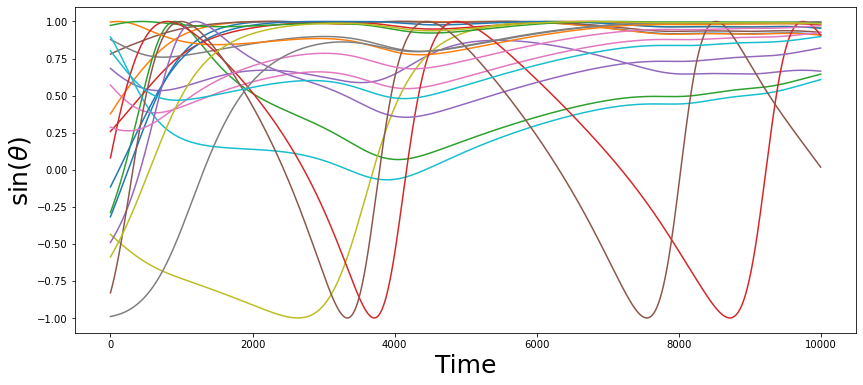

['sim', 'KuramotoBasic', 't', 328.5419999991429, 'X', [2.305059456130038, 2.0416183478554006, 7.933015310237558, 2.284495395744154, 0.5821876107241215, 1.9023104625988434, 2.7138773663265323, 2.270037687417123, 5.471149091818768, 2.9178437764233744, 2.335957630177582, 2.0815899372806053, 1.7698835735470768, 1.3894529145288201, 7.378117187799012, 1.6400837664754, 2.6972523854557187, 3.6188971798653644, 2.675377878901812, 2.6541865685568666], 'dX', [-0.9648428478321127, -0.6050373957378903, 1.8693483148303804, -0.5900233412333447, 0.13711641049549472, -0.34148758751326924, -0.1822221517743663, -0.08544011188848805, -0.25772432298013775, 0.2598136987782176, -0.8146515825453093, 0.2383963684786971, 0.24141955516241687, -1.118175992011136, 2.1208746683146185, -1.6810371654442262, -0.39684113304414503, -1.3225035689760558, -1.0592604878595937, -0.00675852583632075]]
['sim', 'KuramotoBasic', 't', 330.5419999990956, 'X', [1.7013781865192477, 1.6324999926038495, 8.86591520717856, 1.880092812999

In [21]:
# Plot the results using integrate.odeint - this is what we should expect to happen in real-time using Euler

sim.k_coupling = 0.17    # global coupling constant, typical values 0.4-2.0
sim.n_nodes = 10      # number of nodes
sim.natural_frequencies = np.random.normal(size=sim.n_nodes)
fc_graph = nx.erdos_renyi_graph(n=sim.n_nodes, p=1.)
sim.connectivity_matrix = nx.to_numpy_array(fc_graph)
sim.X0 = 2 * np.pi * np.random.random(size=sim.n_nodes)
sim.X = sim.X0
tmax = 25. # simulation length in seconds


sim.k_coupling = 0.10    # global coupling constant, typical values 0.4-2.0
sim.n_nodes = 20      # number of nodes
sim.natural_frequencies = np.random.normal(size=sim.n_nodes)
fc_graph = nx.erdos_renyi_graph(n=sim.n_nodes, p=1.)
sim.connectivity_matrix = nx.to_numpy_array(fc_graph)
sim.X0 = 2 * np.pi * np.random.random(size=sim.n_nodes)
sim.X = sim.X0
tmax = 10. # simulation length in seconds


n_interactions = (sim.connectivity_matrix != 0).sum(axis=0)  # number of incoming interactions
coupling = sim.k_coupling / n_interactions  # normalize coupling by number of interactions
t = np.linspace(0, tmax, int(tmax/sim.h))
timeseries = integrate.odeint(sim.dXfunc, sim.X, t, args=(sim,))
res = timeseries.T  # transpose for consistency (act_mat:node vs time)

print(res.shape, t.shape, sim.X.shape)

_, ax = plt.subplots(figsize=(14, 6))
ax.plot(np.sin(res.T))
ax.set_xlabel('Time', fontsize=25)
ax.set_ylabel(r'$\sin(\theta)$', fontsize=25)

In [38]:
# Keeping track of Cool initial values...
sim.initial_positions = [5.78654724, 5.4724832 , 6.08642436, 3.19053921, 4.11811814, 1.1861428 , 1.05893974, 1.70789335, 1.19946118, 1.01440345]
sim.initial_positions

[5.78654724,
 5.4724832,
 6.08642436,
 3.19053921,
 4.11811814,
 1.1861428,
 1.05893974,
 1.70789335,
 1.19946118,
 1.01440345]

In [7]:
# Main simulation thread
async def sim_task():
    """
    Entry point for Simulation process.
    """
    print("Run Simulation...")
    i=0

    # TODO: Add option to run for N steps
    while run_simulation: # Simulation Step
        timestamp = time.time()
        osc_parcel = ["sim", sim.name, "t", sim.t]
        
        # Do one Euler step
        # https://personal.math.ubc.ca/~pwalls/math-python/differential-equations/first-order/
        sim.dX = sim.dXfunc(sim.X, sim.t, sim)
        sim.X = sim.X + sim.h * sim.dX
        sim.t += sim.h
        
        osc_parcel.append("X"); osc_parcel.append(sim.X.tolist());
        osc_parcel.append("dX"); osc_parcel.append(sim.dX.tolist());

        if i % euler_steps_per_message == 0:
            if send_osc:
                osc_client.send_message(osc_msg_address, osc_parcel)

            if print_every != False:
                if i % print_every == 0:
                    print(osc_parcel)
            
            await asyncio.sleep(message_rate) # scheduler tick

        sim.t += sim.h
        i+=1
    
    print("Exit Simulation")

Integrating with h=0.001 (found h=0.001 in sim)
(20, 10000) (10000,) (20,)


Text(0, 0.5, '$\\sin(\\theta)$')

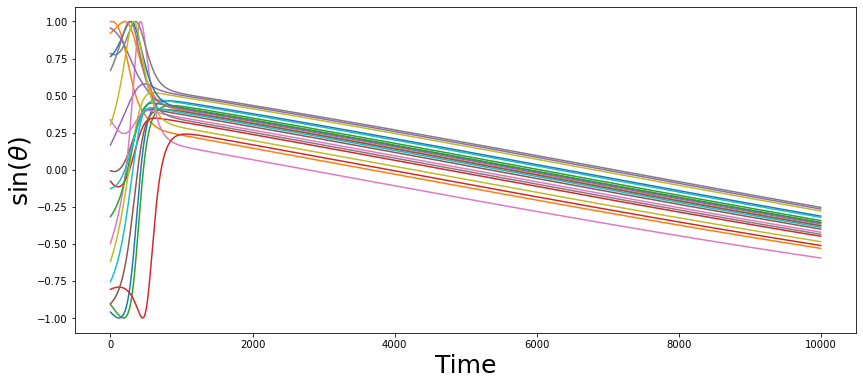

['sim', 'KuramotoBasic', 't', 394.57399999758144, 'X', [4.877354942416117, 1.673196707111842, 5.046477903094709, 3.2478337498337813, 2.9161263302266827, 3.1536153911794886, 5.864040852614523, 0.8879959177701997, 3.6979604339413448, 3.9003332008582694, 0.9167767997950113, 1.239647850215913, 3.419016095342166, 5.3616727595556455, 1.9303188526650625, 4.196212766543458, 2.842261809818856, 0.8222663824876705, 0.40063680472894264, 3.256911729955249], 'dX', [-2.317523544548883, 3.20768136960545, -1.9081012120946217, 0.3560677130969731, -1.0698546203590173, -0.025366519090259776, 1.9008758760685118, -0.012632847613526677, -2.1209164272086984, -1.9074317942949974, 1.1058400418970025, 1.4632809082219045, -0.9349800449415294, 0.22993678295447384, 1.2271484996278927, -1.5450858494305786, 0.7027377186035944, 1.8462695484613993, 1.894066114460514, -0.3276989748271704]]


In [78]:
# Using iterative Euler Method

# Adjusting the step size h is very important here
# need a smaller step size for accurate integration on curvy signals
# this makes the computational cost much higher, also potentially gives accumulated error over time...
# trade off a small h against euler_steps_per_message to keep from sending too many OSC messages
# TODO: Alternatively, if such high resolution is needed, send blocks of the time series as a single message
# sim.h = 0.001
# euler_steps_per_message = 100
# message_rate = 0.1
t = np.arange(0., tmax, step=sim.h)
sim.X = sim.X0

# Integrate for Nt steps
res = euler_integrate(sim.dXfunc, sim.X, t, sim)
res = res.T
print(res.shape, t.shape, sim.X.shape)
_, ax = plt.subplots(figsize=(14, 6))
ax.plot(np.sin(res.T))
ax.set_xlabel('Time', fontsize=25)
ax.set_ylabel(r'$\sin(\theta)$', fontsize=25)

In [24]:
# Stop the simulation...
run_simulation=False
osc_client.send_message(osc_msg_address, ["volume", 0]); # mute sonification

Exit Simulation


In [25]:
# Some reasonable parameters...
message_rate = 0.1
euler_steps_per_message = 5
print_every=1000
send_osc=True
run_simulation=True
sim.X = sim.X0

In [82]:
# Change coupling while sim is running..
euler_steps_per_message = 1
message_rate = 0.1
sim.k_coupling = 2.1    # global coupling constant, typical values 0.4-2.0

In [80]:
# Randomize natural frequencies
sim.natural_frequencies = np.random.normal(size=sim.n_nodes)

['sim', 'KuramotoBasic', 't', 396.57399999753414, 'X', [3.3291868986464275, 2.7493239919189167, 2.4710185697298384, 1.8682294960376824, 2.8646755389055585, 3.5906198928596478, 8.517041317878821, 2.1717851827545878, 3.0010551372525227, 2.911668124556373, 2.597818823795571, 2.055232021084721, 2.6197431175360726, 3.6120176473732193, 2.3593935285688867, 3.0241976716118466, 2.356540690427942, 2.4649688715932525, 2.05045117265948, 2.7736608796790487], 'dX', [-0.5094248024951002, 0.11291315992601497, -1.2716219318473252, -0.9240239435274833, 0.2042906615962477, 0.4882154767609368, 1.676621902175035, 0.8183143688902469, 0.01604604948106758, -0.1949279099770176, 0.7498414767031766, 0.15046197101128767, -0.25551324474035175, -2.4688682248672746, 0.052586213673533, -0.3747516764805538, -0.347867582581057, 0.5597124137482199, 0.5662117841838771, -0.15814660584355608]]
['sim', 'KuramotoBasic', 't', 398.57399999748685, 'X', [3.043723853570938, 2.7812669161879144, 1.8176395611554055, 1.26575372722855

In [66]:
# Randomize positions
sim.X0 = 2 * np.pi * np.random.random(size=sim.n_nodes)
sim.X = sim.X0

['sim', 'KuramotoBasic', 't', 388.5739999977233, 'X', [3.0452830589156505, 3.061808728330448, 3.089253960134931, 3.0320500208969405, 3.0490158027442127, 3.0931756885164767, 3.103526205829679, 3.1560977644972152, 3.029434243693381, 3.0277157542836957, 3.0508887164500784, 3.019859532744602, 3.032684033276447, 3.0793774235727525, 3.0390195106668156, 3.1457139733836548, 3.0252699931648857, 3.0520874995071785, 3.120983184541961, 3.0170437402247416], 'dX', [-0.1217110711051147, 0.6980058579365673, -0.30275313580690244, 0.3681001910209667, 0.3994585512326234, 0.34091423558584033, -1.4504934476672764, 0.8168473439971051, 0.26169570547750376, 0.22384612645872004, 0.9887064554511128, 0.8732744170772986, 0.32457027712147946, -0.46585380113354935, 0.6203699790296683, 0.04600526725980991, 0.4453017529930001, 1.0832120169343717, 1.3275387890237407, 0.3693113758929538]]


In [26]:
# Run simulation...
try:
    osc_client.send_message(osc_msg_address, ["volume", 1.0]); #unmute sonification
    loop=asyncio.get_event_loop()
    task=loop.create_task(sim_task())
    #loop.run_until_complete()
    #await task
    print("Finished simulation...")
except KeyboardInterrupt as e:
    exp = traceback.format_exc()
    raise e
except Exception as e:
    exp = traceback.format_exc()
    print("Exit with Errors")
    raise e
finally:
    # Do any necessary cleanup....
    print("Finished...")

Finished simulation...
Finished...
Run Simulation...
['sim', 'KuramotoBasic', 't', 336.57399999895296, 'X', [3.4632633476004564, 2.754357950137529, 5.991914560508498, 2.8800337926029957, 0.7517513795928396, 2.2473725361491677, 2.534025712095801, 2.0699265812417416, 5.8312738163279825, 2.033723406367544, 3.256855961600025, 1.4825467201755291, 1.339590266714071, 3.0593116375386624, 5.771517259025993, 4.118229352522173, 2.8508240819473962, 4.570642463799669, 3.769293586491362, 2.212465416911883], 'dX', [-1.2688518292893822, -0.8213707157244912, 1.3567912901505303, -0.5562362199480748, -0.5712284895540717, -0.38484624568573444, 0.667039620919758, 0.501655355130671, -0.4925639050097326, 1.6745603388031878, -0.9612801901353063, 0.8363633244422793, 0.44657949883254355, -2.3751521900745884, 0.8912528549972233, -3.0864942386005487, 0.19999365253886858, -0.6107340980771077, -1.0028691465117907, 0.998354134179197]]
['sim', 'KuramotoBasic', 't', 338.57399999890566, 'X', [2.257088980114762, 2.01146

# Future

## Modifications to Basic Kuramoto

* Adding a controllable "decoherence" noise parameter

* A more complex connectivity graph, including per-connection coupling parameters


## Second Order ideas:
* Implementing "memory" into oscillator/agents, so that if a synchronization has been made in the past, it can remember this and adjust its own coupling parameters.